In [353]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh_TGV1')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import Optics
from HHG import ActiveGrating
import Graph

Grating = Optics.Grating()

In [692]:
IR = Optics.Pulse(w0=100e-6, lam=1.03e-6, wt=30e-15)
IR2 = Optics.Pulse(w0=100e-6, lam=1.03e-6, wt=30e-15)

# Grille x-t
grid = IR.Grid(Lx=2e-3, Ly=600e-15, Nx=1601, Ny=4801)
dump, xw_grid = Grating.Disperse(field_0=grid, grid_xt=grid)

# Pulse initiale
lam = 1030e-9
omega = 3e8/lam * 2*np.pi
dt = 30e-15
domega = 2/dt
wi = 5e-3
w0 = 100e-6
ell = 1
theta_sw = np.arctan2(xw_grid[0]/wi, xw_grid[1]/domega)
offset = -3*w0
tilt = 50

PULSE = np.exp(-xw_grid[0]**2/wi**2) * np.exp(-(xw_grid[1] - omega)**2/domega**2)
coord = (xw_grid[0]/wi - tilt*(xw_grid[1]-omega)/omega)
STOV = PULSE * np.exp(-1j*ell*theta_sw)

REF = 0.2*np.exp(-(xw_grid[0] - offset)**2/w0**2*4) * np.exp(-(xw_grid[1] - omega)**2/domega**2)

#STOV = 1*IR.LG_STOV(grid[0], 0, grid[1], l=1, p=0) # Axis0 = time, Axis1 = x
#REF = 0.8*IR2.LG_STOV((grid[0]-offset), 0, grid[1], l=0, p=0) # Axis0 = time, Axis1 = x

DRIVER_sw = STOV + REF

DRIVER, grid_xt = Grating.Recombine(field_0=DRIVER_sw, grid_xt=xw_grid)

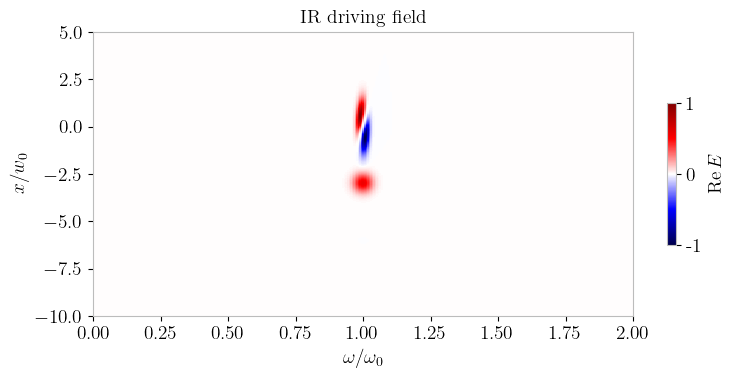

In [688]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 4))

x, w = xw_grid[0][0], xw_grid[1].T[0] # retrieve axes from meshgrid
x = x/w0
w = w/omega
extent=[w[0], w[-1], x[0], x[-1]]

im = ax.imshow(np.real(DRIVER_sw).T/np.max(np.real(DRIVER_sw)), cmap='seismic', aspect='auto', extent=extent, vmin=-1, vmax=1)

cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
cbar.ax.set_yticklabels(['-1', '0', '1'])
cbar.ax.set_ylabel('$\Re E$')


ax.set_xlim(0, 2)
ax.set_ylim(-10,5)

ax.set_xlabel('$\omega/\omega_0$')
ax.set_ylabel('$x/w_0$')

#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax.set_title('IR driving field')

plt.show()

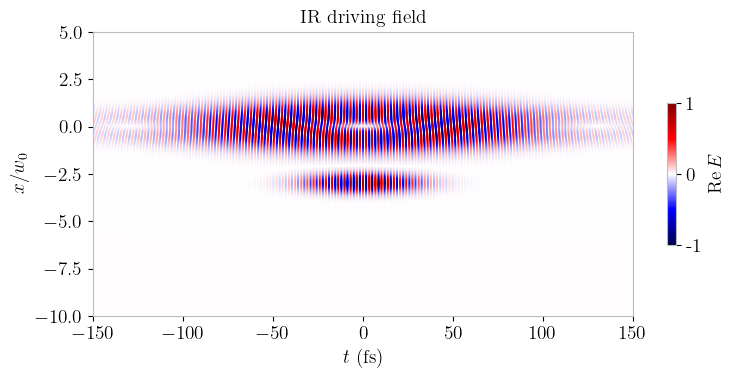

In [678]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 4))

x, t = grid[0][0], grid[1].T[0] # retrieve axes from meshgrid
x = x/IR.w0
t = t/1e-15
extent=[t[0], t[-1], x[0], x[-1]]

im = ax.imshow(np.real(DRIVER).T/np.max(np.real(DRIVER)), cmap='seismic', aspect='auto', extent=extent, vmin=-1, vmax=1)

cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
cbar.ax.set_yticklabels(['-1', '0', '1'])
cbar.ax.set_ylabel('$\Re E$')


ax.set_xlim(-150, 150)
ax.set_ylim(-10,5)

ax.set_xlabel('$t \ \mathrm{(fs)}$')
ax.set_ylabel('$x/w_0$')

#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax.set_title('IR driving field')

plt.show()

In [689]:
"Compute HH near field with TSM"
AG = ActiveGrating(qeff=3.5)
XUV_STOV = 0

for q in [9, 11, 13]:
    XUV_STOV += AG.Hq_NearField(IRfield=DRIVER, q=q)

# we want the frequency axis to span [-q-1, q+1]. We need to adjust N/T to optimize this. 
# Then, to increase the spectral resolution we need to increase N and T by the same factor. Could be done by zero padding

"Fourier transform in time (effect of the grating)"
XUVspectrum, xw_grid = Grating.Disperse(field_0=XUV_STOV, grid_xt=grid)


In [690]:
"Propagate every frequency component to the far-field"

x, w = xw_grid[0][0], xw_grid[1].T[0] # retrieve axes from meshgrid
Lx, Lw = x[-1]-x[0], w[-1]-w[0]
Nx, Nw = len(x), len(w)

# we want the frequency axis to roughly span [-lam/w0, lam/w0] ~20mrad . We need to adjust N/L to optimize this. 
# Then, to increase the spectral resolution we need to increase N and T by the same factor. Could be done by zero padding

test = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(XUVspectrum, axes=1), axis=1), axes=1)
test = test * (Lx/(Nx-1))
d=1
xp = np.fft.fftshift(np.fft.fftfreq(Nx, Lx/(Nx-1)))*d
lam_axis = 2*np.pi*3e8/w

for i in range(len(test)):
    test[i] = np.interp(xp*lam_axis[0], xp*lam_axis[i], test[i]) / lam_axis[i] 

C:\Users\tg263331\AppData\Local\Temp\ipykernel_2504\466489221.py:14: RuntimeWarning: divide by zero encountered in divide
  lam_axis = 2*np.pi*3e8/w
C:\Users\tg263331\AppData\Local\Temp\ipykernel_2504\466489221.py:17: RuntimeWarning: invalid value encountered in multiply
  test[i] = np.interp(xp*lam_axis[0], xp*lam_axis[i], test[i]) / lam_axis[i]


In [691]:
"Plot far-field XUV spectrum"

%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(6,3))

x, w = xp*lam_axis[0], xw_grid[1].T[0]
x = x*1e3
w = w/IR.omega
extent=[w[0], w[-1], x[0], x[-1]]
print(extent)


#im = Graph.Phase2D().colorize(test.T, mode='Amplitude')
# ins = Graph.Phase2D().key_inset(mode='Amplitude', ax=ax)
#ax.imshow(im, aspect='auto', extent=extent)

ax.imshow(np.abs(test.T)**2, aspect='auto', extent=extent, cmap='Blues_r')
#ax.imshow(np.angle(test.T), aspect='auto', extent=extent, cmap='hsv')

ax.set_xlim(8, 14)
ax.set_ylim(-6, 6)

ax.set_xlabel(r'$\omega/\omega_{IR}$')
ax.set_ylabel(r'$\theta \ \mathrm{(mrad)}$')

ax.hlines(0, 0, 30, colors='r', linewidth=0.5)

#ax.set_xticks([7, 9, 11, 13, 15, 17, 21, 23], [7, 9, 11, 13, 15, 17, 21, 23])
#ax.set_yticks([-10, -5, 0, 5, 10], [-10, -5, 0, 5, 10])

ax.set_title('XUV spectrum')

plt.show()

[-13.730472818162887, 13.730472818162887, 29.987507807620233, -29.987507807620233]


[-13.730472818162887, 13.730472818162887, -10.0, 10.0]


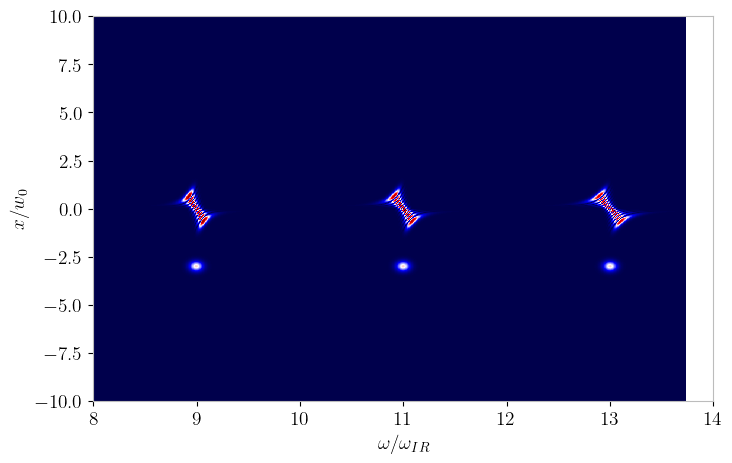

In [685]:
"Plot near-field XUV spectrum"
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(8,5))

x, w = xw_grid[0][0], xw_grid[1].T[0] # retrieve axes from meshgrid
x = x/IR.w0
w = w/IR.omega
extent=[w[0], w[-1], x[0], x[-1]]
print(extent)

ax.imshow(np.abs(XUVspectrum).T, cmap='seismic', aspect='auto', extent=extent)

ax.set_xlim(8, 14)
ax.set_ylim(-10, 10)

ax.set_xlabel(r'$\omega/\omega_{IR}$')
ax.set_ylabel(r'$x/w_0$')

#ax.set_xticks([11, 13, 15], [11, 13, 15])

plt.show()

In [683]:
"Plot total XUV field in xt"
%matplotlib qt
fig, ax = plt.subplots(1, 1, tight_layout=True)

x, t = grid[0][0], grid[1].T[0] # retrieve axes from meshgrid
x = x/IR.w0
t = t/1e-15
extent=[t[0], t[-1], x[0], x[-1]]

val=np.abs(XUV_STOV).T/np.max(np.abs(XUV_STOV))
im = ax.imshow(np.log(val), cmap='inferno', aspect='auto', extent=extent, vmin=-100)

cbar = plt.colorbar(im, orientation='vertical', shrink=0.5, aspect=15)
cbar.ax.set_ylabel('$|E|$')


ax.set_xlim(-200, 200)
ax.set_ylim(-20,5)

ax.set_xlabel('$t \ \mathrm{(fs)}$')
ax.set_ylabel('$x/w_0$')

#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax.set_title('Harmonic field')

plt.show()